# Microbial Growth Simulation
We start with a simple stochastic model and then we will move to more complex models. In this model we consider non-interacting cells, which undergo 2 processes:
- **growth:** the cell size $x(t)$ evolves according to the following equation
    $$
    \dot{x}=g(x(t)) \quad, \quad x(0)=x_b
    $$
- **division:** it is ruled by the _hazard rate function_ $h(x(t))$, which represents the istantaneous probability of the cell to divide. This function is related to the so called _survival function_ $s(t)$, by the relation
    $$
    \frac{\dot{s}(t)}{s(t)}=-h(t) \quad , \quad s(0)=1
    $$
    where $s(t)$ gives the probability that the cell will survive (meaning not divide in this case) past a certain time $t$.

While the growth is a deterministic process, division is a stochastic event. In this first model we define $g(x)$ and $h(x)$ as 2 linear functions
$$
\begin{aligned}
g(x) &\equiv \omega_1(\mu+x) \\
h(x) &\equiv \omega_2(1+x/\nu)
\end{aligned}
$$
where $\omega_1$ and $\omega_2$ are frequencies, while $\mu$ and $\nu$ are sizes (tipycally measured in $\mu m$). The ratio between $\omega_1$ and $\omega_2$ is the order parameter that triggers the phase transition. The parameters $\mu$ and $\nu$ are necessary to cut off the probability distribution (in zero and for large values of $x$), which is important both for physical reasons and for making the distribution normalizable.

As a result, our set of parameters is 
$$
\underline{\theta}=\{\mu, \nu, \omega_1, \omega_2, x_b\}
$$


## Simulation process
The idea is first of all to solve analytically the following differential equation for the size $x(t)$ of one single cell
$$
\begin{dcases}
x(0) =  x_b  \\
\dot{x} = \omega_1 \left(x(t) + u\right)
\end{dcases}
$$
where $x_b$ is the cell size at birth. 

Then, we plug $x(t)$ into
$$
h(x(t)) = \omega_2 \left(1 + \frac{x(t)}{\nu}\right)
$$


Next, we use the found result for $h(x(t))$ to solve:
$$
\begin{dcases}
s(0) =  1  \\
\dfrac{\dot{s}(t)}{s(t)} = -h(x(t))
\end{dcases}
$$
Once we have $s(t)$ we can generate random division times from this distribution using the **inverse transform method**. Finally, we can deterministically propagate the solution to find $x(t)$. 


## Analytical solution of the differential equations
The result of two differential equations is:
$$
\begin{aligned}
s(t) &= \exp\left\{ \omega_2t \left(\frac{u}{\nu}-1\right) + \frac{\omega_2}{\omega_1}\left(\frac{u + x_b}{\nu}\right)(1-e^{\omega_1t})\right\} \\
\ln(s) &= \omega_2 t \left(\frac{u}{\nu}-1\right) + \frac{\omega_2}{\omega_1} \left(\frac{u+x_b}{\nu}\right) (1-e^{\omega_1 t})
\end{aligned}
$$

and $x(t)$ is given by
$$
x(t) = \left(x_b+\frac{\mu}{\omega_1}\right)e^{\omega_1 t}-\frac{\mu}{\omega_1}
$$


## Sampling from the distribution
Following the inverse transform method, to draw a division time, $t_d$, from the associated distribution, we draw a random value $s(t)$ from a uniform distribution in the intervall $[0, 1]$ (i.e. “draw a survival probability”) and solve for $t_b$

$$ 
\log(s(t_b)) = \log(K)
$$


 In systems with many cells, the division times will generally be very small. Therefore, we expand the equation found for $$ s(t) $$ up to the second order in $$ t $$ and solve the resulting equation, from which we derive the approximate division time:

$$
 t_b = - \dfrac{1}{\omega_1} \left(\dfrac{x_b + \nu}{x_b + u}\right) + \dfrac{1}{\omega_1} \left(\dfrac{\nu}{x_b + u}\right) \sqrt{\left( \dfrac{x_b}{\nu} +1 \right)^{2} -2 \cdot \dfrac{\omega_1}{\omega_2} \left(\dfrac{x_b + u}{\nu}\right) \log(K) }

$$

After a division time has been simulated, individually for each cell, and the shortest time until the next death event occurs has been simulated, for all cells simultaneously, the smallest of these times is
chosen and the corresponding event is executed.

In [1]:
import math
import numpy as np
from scipy import stats
# import sympy as smp
import pandas as pd
# from sympy.abc import t, a, b, c, d, e
import emcee
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm

In [2]:
import plotly.express as px

In [3]:
np.random.seed(seed=123)

size = 100 # length of the time series (= number of divisions)
s_drawn = np.random.uniform(low=0, high = 1, size = size)
print('Some drawn values of s:', s_drawn[:5])

Some drawn values of s: [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


In [4]:
# In the following code cell we rename:
# - $a=\omega_1$
# - $b=\omega_2$
# - $c=\mu$
# - $d=\nu$
# - $e=x_b$

# def x(t):
#     return(np.e**((b*t*(c-1) + (a/b)*((c + e)/d)*(1-np.e**(-a*t)))))

#smp.solve(x(t)-0.5, t)    #find the value of t in which x(t) - 0.5 = 0 

## Parameters value, initial choices
Initially, we can choose arbitrary values for the parameters, as long as they make sense. For this reason, we decide to set and fix
- $\omega_1=1$
- $\nu=1$

Then we chose for now
- $\omega_2=0.9$ 
- $\mu=0.1$, such that $\mu \ll\nu$
- $x_b=1$


In [5]:
# def log_s (t, pars):
#     (omega1, omega2, u, nu, xb) = pars
# 
#     log_s_t = (omega2/omega1)*((xb+u)/nu) + omega2*(u/nu - 1)*t - (omega2/omega1)*((xb+u)/nu)*np.exp(omega1*t)
#     return log_s_t

'''
Find tau analytically, using the second order approximation
'''
def draw_tau(K, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    tau = -(1/omega1)*((xb+nu)/(xb+mu)) + (1/omega1)*(nu/(xb+mu)) * np.sqrt((1+xb/nu)**2 - 2*(omega1/omega2)*((xb+mu)/nu)*np.log(K))
    return tau


In [6]:
sim_t = draw_tau(s_drawn)
df_growth = pd.DataFrame({'simulated_tau':sim_t, 's_drawn':s_drawn})

display(df_growth)

,simulated_tau,s_drawn
0,0.190936,0.696469
1,0.597106,0.286139
2,0.692331,0.226851
3,0.305191,0.551315
4,0.174535,0.719469
...,...,...
95,0.194387,0.691702
96,0.850755,0.151127
97,0.453945,0.398876
98,0.668112,0.240856


In [7]:
'''
Cell size evolution x(t)
'''
def x_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    x = (xb+mu/omega1)*np.exp(omega1*t)-mu/omega1
    return x
    
'''
Hazard rate function h(t)
'''
def h(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    h = omega2*(1+x_function(t, pars)/nu)
    return h

'''
Survival function s(t)
'''
def CDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
    return s

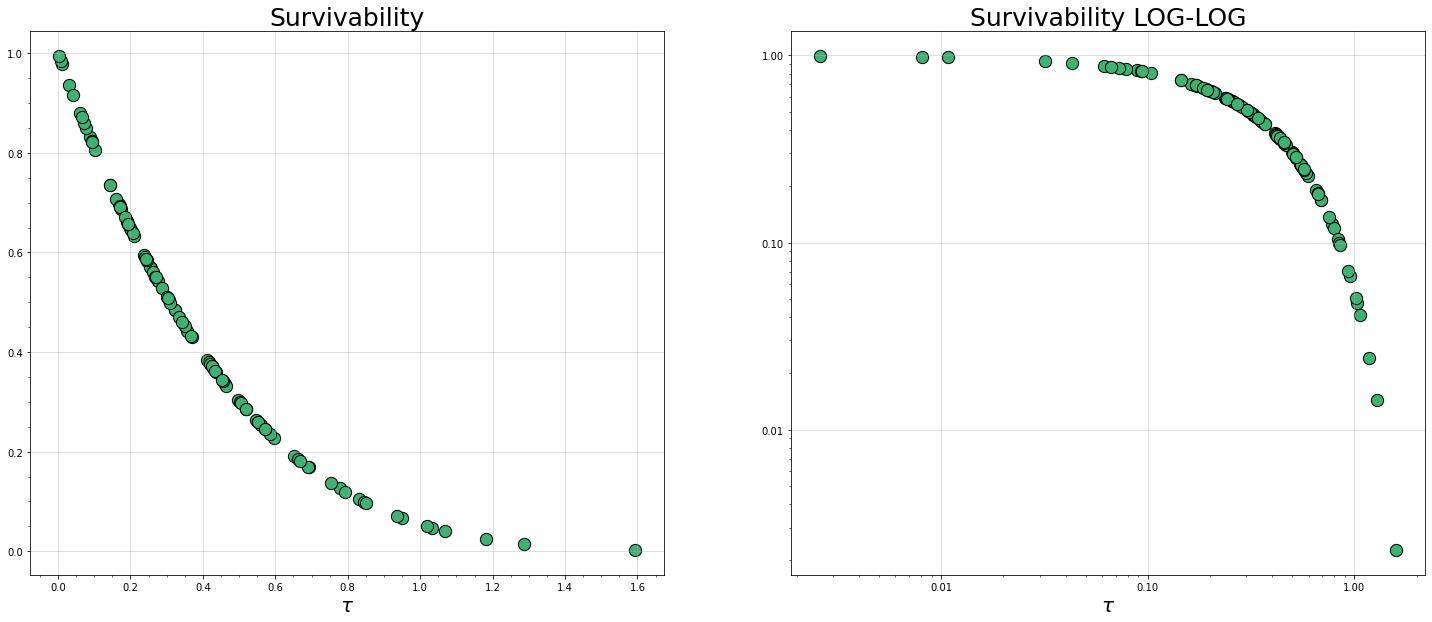

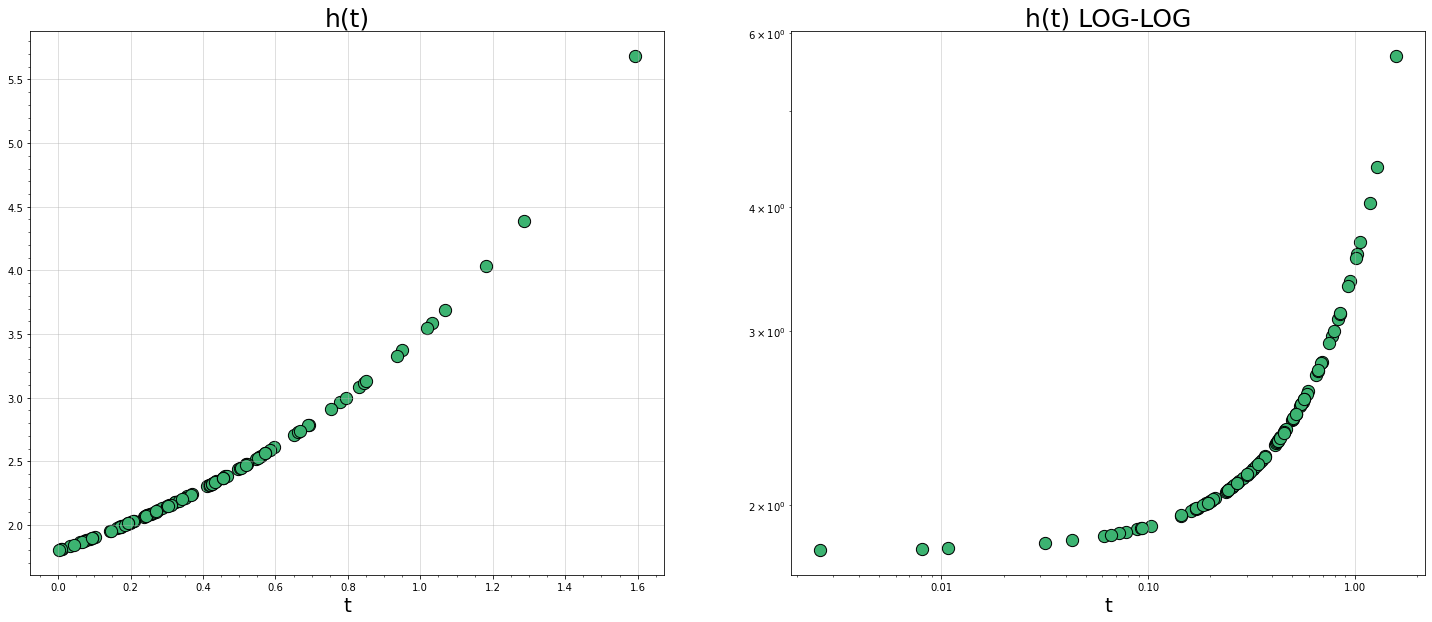

In [8]:
# PLOT s(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('Survivability', fontsize=25)
ax[0].set_xlabel('$\\tau$', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)

ax[1].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('Survivability LOG-LOG', fontsize=25)
ax[1].set_xlabel('$\\tau$', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# PLOT h(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('h(t)', fontsize=25)
ax[0].set_xlabel('t', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)

ax[1].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('h(t) LOG-LOG', fontsize=25)
ax[1].set_xlabel('t', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

## Forward propagation
At this point, given the time series of the survival times, we can forward propagate the evolution of a single cell, according to the following procedure:

1. Start with the initial size $x_b$
2. Propagate using the equation for $x(t)$ up to the first division time
3. Divide the cell size by 2 (assuming the cell divides equally in two parts)
4. Repeat the last 2 points for all division times generated, imposing as initial size of the cell the one after division and resetting the time

Recall that in this model the cell growth is a deterministic process, while the division is stochastic.


In [9]:
points_per_evolution=100     # number of time points between 2 divisions

t = 0
xb = 1

all_times = np.zeros(points_per_evolution*size)
cell_sizes = np.zeros(points_per_evolution*size)

for i in range(size): 
    parameters = (1,0.9,0.1,1,xb) # omega1, omega2, mu, nu, xb
    tau = df_growth['simulated_tau'][i]

    # evolution
    times = np.linspace(0, tau, points_per_evolution)
    xt = x_function(times, parameters)
    
    # store times and sizes
    all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
    cell_sizes[i*points_per_evolution : (i+1)*points_per_evolution] = xt

    # update the initial time and the starting size
    xb = xt[-1]/2
    t = t+tau


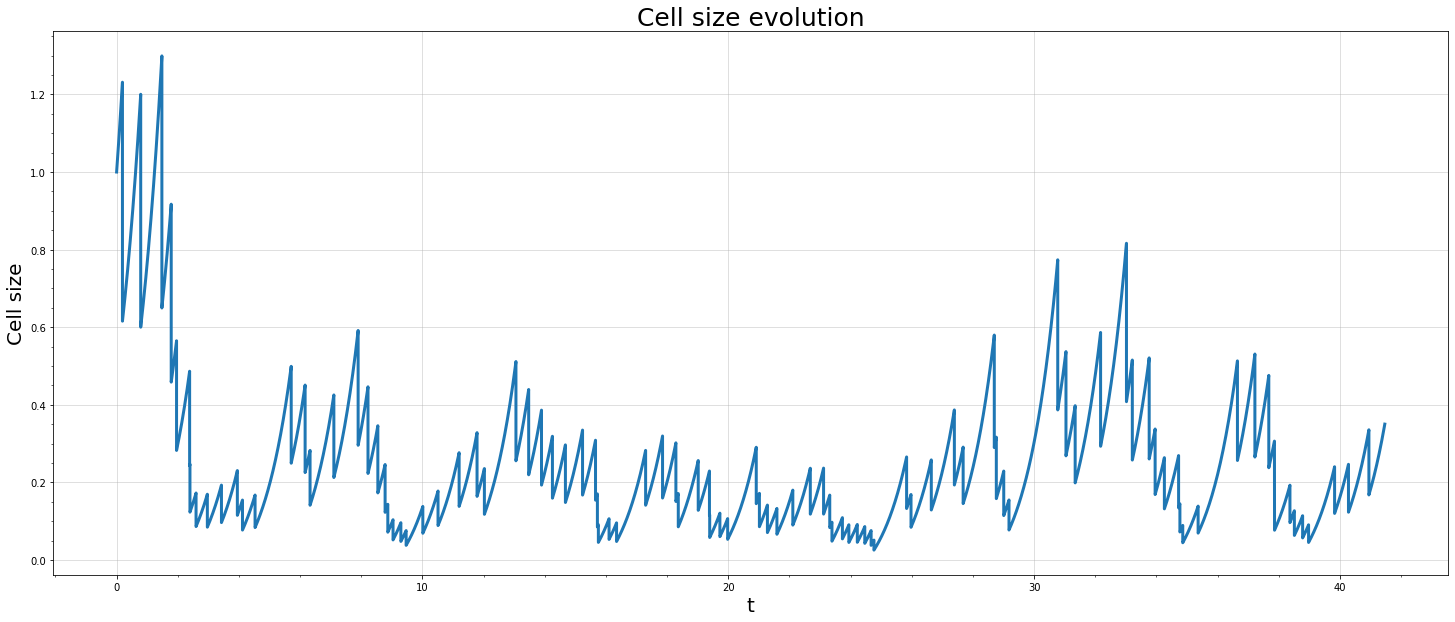

In [10]:
fig, ax = plt.subplots(1,1 , figsize=(25, 10))
ax.plot(all_times, cell_sizes, linewidth=3, color='C0')
ax.set_title('Cell size evolution', fontsize=25)
ax.set_xlabel('t', fontsize = 20)
ax.set_ylabel('Cell size', fontsize=20)
ax.minorticks_on()
ax.grid(alpha=0.5)

## Priors 
For now, we consider $\omega_1$, $\nu$ and $x_b$ constant, so that the only parameters to be inferred are $\omega_2$ and $\mu$. 

For $\omega_2$, we choose as prior a log-normal distribution. This is motivated by the fact that $\omega_2$ must be positive. Moreover, according to the previous choices of the parameter values, we set as parameters $\mu=????$ and $\sigma=????$. 

Instead, as $\mu$ must be smaller than $\nu$ and we imposed $\nu=1$, we adopt for $\mu$ a beta prior, which is restricted between 0 and 1. Assuming a greater probability for values closer to zero than to one and a pdf that goes to zero in both extremes, one possible choice can be to set $\alpha=2$ and $\beta=5$. 

<br>

**Some information on the log-normal distribution** <br>
The pdf of the log-normal distribution is characterized by 2 parameters:
- $\mu$: the location parameter
- $\sigma$ the scale parameter

These two parameters must not be confused with the mean and standard deviation of the distribution. When the log-normal data is transformed using logarithms, then $\mu$ can then be viewed as the mean (of the transformed data) and $\sigma$ as the standard deviation (of the transformed data). But without these transformations $\mu$ and $\sigma$ here are simply two parameters that define our log-normal, not the mean or standard deviation! Reference: [Log-normal Distribution - A simple explanation](https://towardsdatascience.com/log-normal-distribution-a-simple-explanation-7605864fb67c). 

About how this parameters are managed by `scipy`, we report here what is described in the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html).

> To shift and/or scale the distribution use the loc and scale parameters. Specifically, lognorm.pdf(x, s, loc, scale) is identically equivalent to lognorm.pdf(y, s) / scale with y = (x - loc) / scale. Note that shifting the location of a distribution does not make it a “noncentral” distribution; noncentral generalizations of some distributions are available in separate classes. 
>
> A common parametrization for a lognormal random variable Y is in terms of the mean, mu, and standard deviation, sigma, of the unique normally distributed random variable X such that exp(X) = Y. This parametrization corresponds to setting s = sigma and scale = exp(mu).

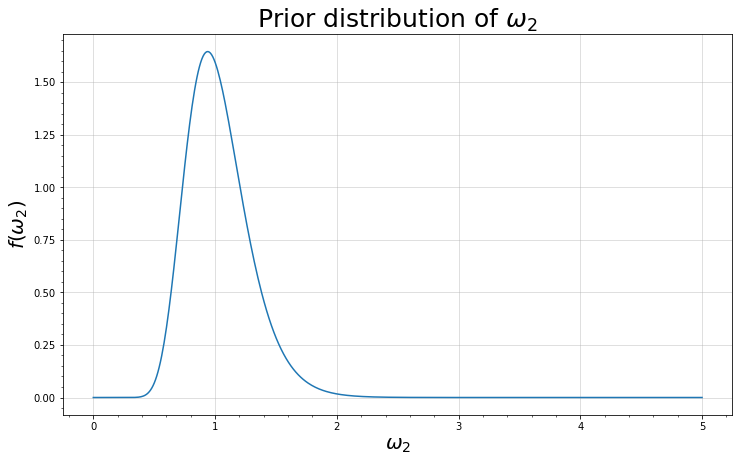

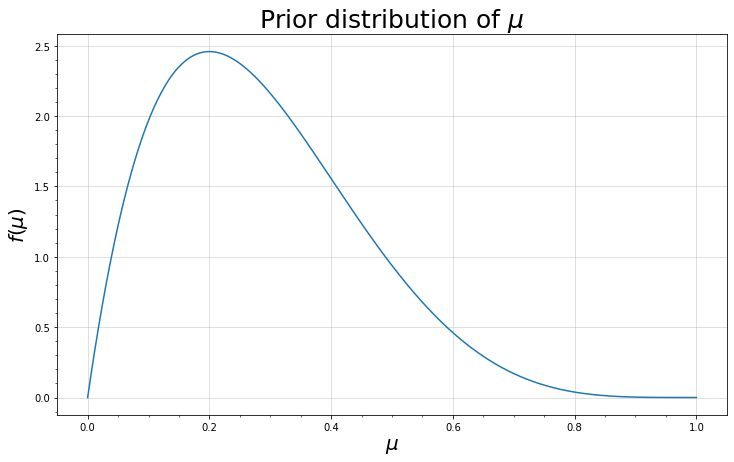

In [11]:
# plot of the prior distributions

x = np.linspace(0, 5, 500)

mu_par = 0       # ???????????????????????????
sigma_par = 0.25 # ???????????????????????????

_, ax = plt.subplots(figsize=(12,7))
ax.plot(x, stats.lognorm.pdf(x, s=sigma_par, loc=0, scale=np.exp(mu_par))) 
ax.set_title('Prior distribution of $\omega_2$', fontsize=25)
ax.set_xlabel('$\omega_2$', fontsize = 20)
ax.set_ylabel('$f(\omega_2)$', fontsize=20)
ax.minorticks_on()
ax.grid(alpha=0.5)


x = np.linspace(0, 1, 500)

_, ax = plt.subplots(figsize=(12,7))
ax.plot(x, stats.beta.pdf(x, a=2, b=5))
ax.set_title('Prior distribution of $\mu$', fontsize=25)
ax.set_xlabel('$\mu$', fontsize = 20)
ax.set_ylabel('$f(\mu)$', fontsize=20)
ax.minorticks_on()
ax.grid(alpha=0.5)


In [12]:
# define the distributions
def prior_omega2(omega2):
    return(stats.lognorm.pdf(omega2, s=sigma_par, loc=0, scale=np.exp(mu_par)))

def prior_mu(mu):
    return(stats.beta.pdf(mu, a=2, b=5))

## Likelihood

To retrieve the likelihood we first retrieve the pdf as minus the derivative of the cdf.
We then have that 
$$
f(y|\theta) = \prod_i f(t_i|t_{i-1,..}, \theta)
$$

In [13]:
def PDF_old(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars
    unnormalized = -1*CDF(t, pars=pars) * (omega2*((mu/nu) - 1) - omega2*((mu + xb)/nu) * np.exp(omega1*t))
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])
    return(unnormalized/normalization)


def PDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    unnormalized = h(t, pars)*CDF(t, pars)
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])

    return(unnormalized/normalization)

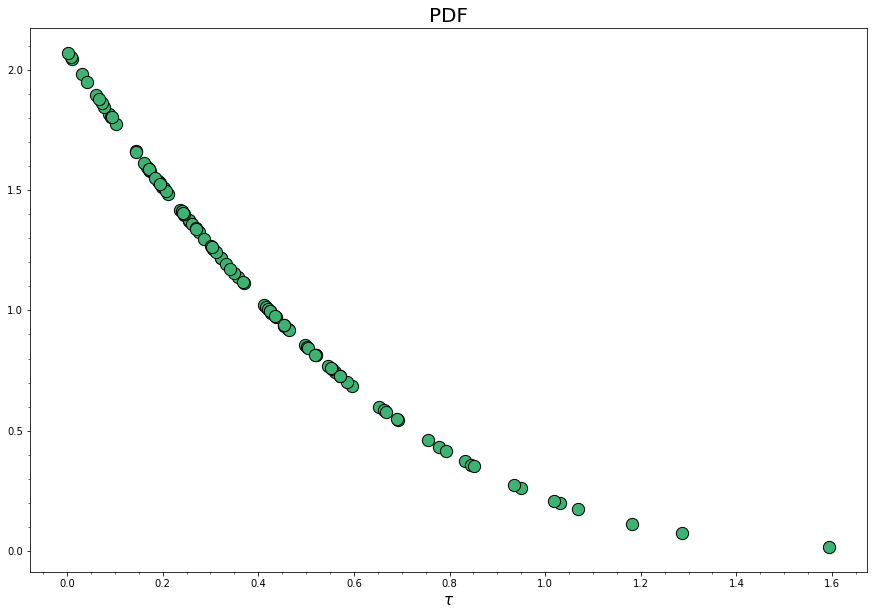

In [14]:
def likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.prod(PDF(y, pars))

def log_likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.sum(np.log(PDF(y, pars)))

fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.scatter(sim_t, PDF(sim_t, pars=(1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax.set_title('PDF', fontsize=20)
ax.set_xlabel('$\\tau$', fontsize = 15)
ax.minorticks_on()

## Manual MCMC

### This first part acts only on $\omega_2$
The goal is to estimate the value of the parameter $\omega_2$ from the simulated data. In order to do this, we use the log distributions. 

In [15]:
def jump_distribution(mean_omega = 1):
    draw = np.random.normal(loc=mean_omega, scale=0.5, size=1)
    return(float(draw))

In [16]:
def unnorm_posterior(y_times, omega_2):
    return(likelihood(y_times, pars=(1, omega_2, 0.1, 1, 1)) * prior_omega2(omega_2))

def log_unnorm_posterior(y_times, omega_2):
    return(log_likelihood(y_times, pars=(1, omega_2, 0.1, 1, 1)) + np.log(prior_omega2(omega_2)))

In [17]:
def post_sampler(array, jump, initial, num_sampled, maxiter=1000000):
    np.random.seed(12345)

    samples_post = []
    omega_2 = initial
    samples_post.append(omega_2)
    
    sampled = 1
    i=0

    while (sampled < num_sampled and i<maxiter):
        #print(sampled)

        proposal = jump(omega_2)
        prob = np.min([1, (unnorm_posterior(array,proposal))/(unnorm_posterior(array, omega_2))])
        cutoff = np.random.uniform(size=1)

        if cutoff <= prob:
            omega_2 = proposal
            samples_post.append(proposal)
            sampled +=1
        
        i+=1
    
    return(np.array(samples_post))


def log_post_sampler(array, jump, initial, num_sampled, maxiter=1000000):
    np.random.seed(12345)

    samples_post = []
    omega_2 = initial
    samples_post.append(omega_2)
    
    sampled = 1
    i=0

    while (sampled < num_sampled and i<maxiter):
        #print(sampled)

        proposal = jump(omega_2)
        prob = np.min([1, np.exp(log_unnorm_posterior(array,proposal)-log_unnorm_posterior(array, omega_2))])
        cutoff = np.random.uniform(size=1)

        if cutoff <= prob:
            omega_2 = proposal
            samples_post.append(proposal)
            sampled +=1
        
        i+=1
    
    return(np.array(samples_post))
        

In [18]:
def unnorm_post(tmp, omega_2):
    return(likelihood(tmp, pars=(1, omega_2, 0.1, 1, 1)) * prior_omega2(omega_2))
    
unnorm_post(sim_t, 0.9)
# yaxis = yaxis[idx]
# normalization = np.trapz(x=y_times, y=unnorm_post(y, omega_2))

0.0014449723581027357

In [19]:
# using log distribution
sample = log_post_sampler(array=sim_t, jump=jump_distribution, initial = 0.9, num_sampled=10000)
sample[0:20]

<ipython-input-16-97fed9f27c33>:5: RuntimeWarning: divide by zero encountered in log
  return(log_likelihood(y_times, pars=(1, omega_2, 0.1, 1, 1)) + np.log(prior_omega2(omega_2)))
<ipython-input-7-0729c5d6e9ad>:25: RuntimeWarning: overflow encountered in exp
  s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
<ipython-input-13-8695b04bc8d9>:16: RuntimeWarning: invalid value encountered in true_divide
  return(unnormalized/normalization)


array([0.9       , 0.79764617, 1.03711784, 0.76724712, 1.00573962,
       1.28581227, 0.75405604, 0.9204974 , 1.10948946, 1.23282651,
       0.77319573, 1.15237731, 1.17738198, 1.16563532, 0.91409163,
       0.93974968, 0.87396088, 0.96806622, 0.98287129, 1.05920958])

Text(0.5, 1.0, '$\\omega_2$ posterior')

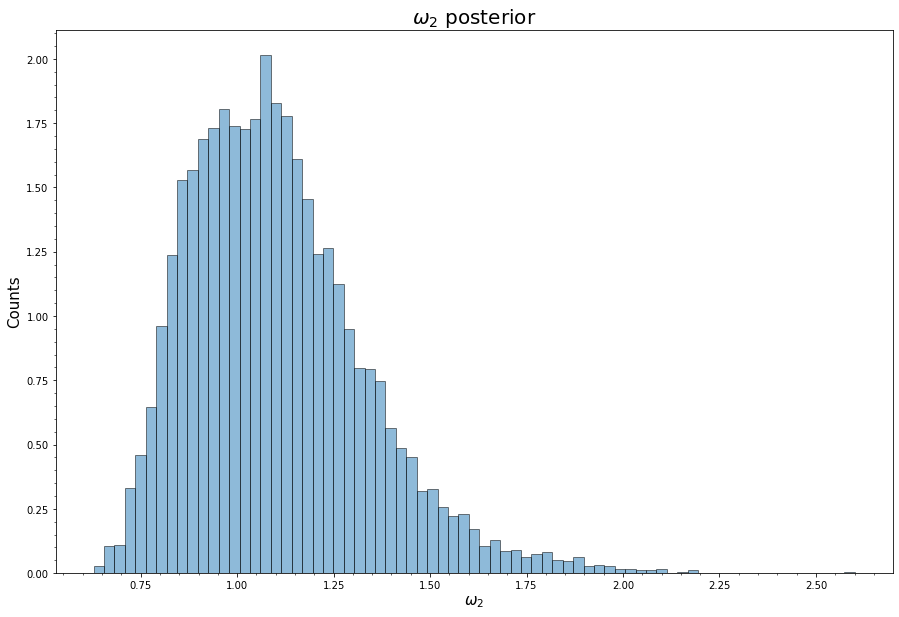

In [20]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.hist(sample, edgecolor='black', alpha = 0.5, bins='fd', density = True)
ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_2$', fontsize=15)
ax.set_title('$\\omega_2$ posterior', fontsize=20)

### This part acts on both $\omega_2$ and $\mu$
In this case we don't use the log distributions, as some warnings still occured in the previous section (e.g. "divide by zero encountered in log"). If we will solve the problem in the one-dimensional case, than we will use that approch in this part as well. 

The goal is to infer from the simulated data both $\omega_2$ and $\mu$. 

In [21]:
def joint_jump(mean_omega = 1, mean_mu = 1):
    draw = np.random.multivariate_normal(mean=[mean_omega, mean_mu], cov = [[1, 0], [0, 1]])
    return(draw)

In [22]:
def joint_posterior(y, omega_2, mu):
    return(likelihood(y, pars=(1, omega_2, 0.1, 1, 1)) * prior_omega2(omega_2) * prior_mu(mu))

In [23]:
def joint_post_sampler(array, jump, initial, num_iterations):
    samples_omega = []
    samples_mu = []
    omega_2 = initial[0]
    mu_ = initial[1]
    samples_omega.append(omega_2)
    samples_mu.append(mu_)
    for i in range(num_iterations):
        proposal = jump(omega_2, mu_)
        prob = np.min([1, (joint_posterior(array,proposal[0], proposal[1]))/(joint_posterior(array, omega_2, mu_))])
        cutoff = np.random.uniform(size=1)
        if cutoff <= prob:
            omega_2 = proposal[0]
            mu_ = proposal[1]
            samples_omega.append(proposal[0])
            samples_mu.append(proposal[1])
    
    return(samples_omega, samples_mu)

In [24]:
sample_omega, sample_mu = joint_post_sampler(array=sim_t, jump=joint_jump, initial=[0.9, 0.1], num_iterations=10000)

<ipython-input-7-0729c5d6e9ad>:25: RuntimeWarning: overflow encountered in exp
  s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
<ipython-input-13-8695b04bc8d9>:16: RuntimeWarning: invalid value encountered in true_divide
  return(unnormalized/normalization)


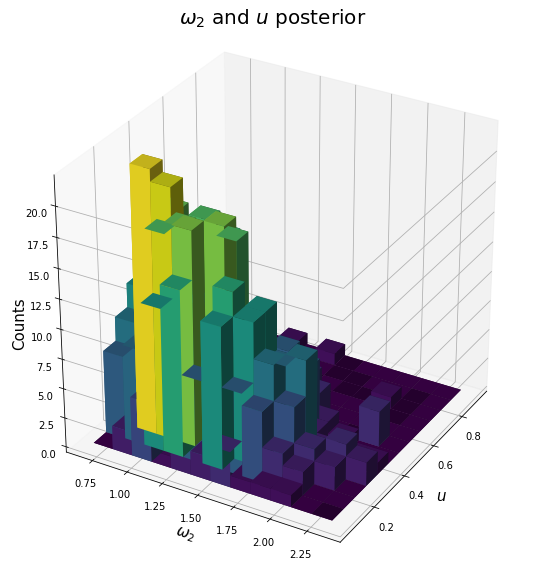

In [26]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(sample_omega, sample_mu, bins=(12,12))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)
cmap = cm.get_cmap('viridis')
# Construct arrays with the dimensions for the bars.


dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]

dz = hist.ravel()
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz]
ax.set_xlabel('$\\omega_2$', fontsize=15)
ax.set_ylabel('$u$', fontsize=15)
ax.set_box_aspect([1,1,1])
tmp_planes = ax.zaxis._PLANES
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel("Counts" , fontsize=15, rotation=90)
ax.set_title('$\\omega_2$ and $u$ posterior', fontsize=20)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
fig.tight_layout()

In [28]:
import plotly.express as px
fig=px.density_heatmap(x=sample_omega, y=sample_mu, nbinsx=16, nbinsy=16, width=700, height=500, marginal_y='histogram', marginal_x='histogram')
xmin, xmax, ymin, ymax = xedges[0], xedges[-1], yedges[0], yedges[-1]

fig.update_layout(
    title="Posterior heatmap",
    xaxis_title="$\omega_2$",
    yaxis_title="$\mu$",
)
fig.show()

In [29]:
import plotly.graph_objects as go

import numpy as np

fig = go.Figure(go.Histogram2dContour(
        x = sample_omega, 
        y = sample_mu,
        colorscale = 'Blues', 
        contours = dict(
            showlabels = True,
            labelfont = dict(
                family = 'Raleway',
                color = 'firebrick', 
                size=20
            )
        ),
))

fig.update_layout(
    title="Posterior heatmap",
    xaxis_title="$\omega_2$",
    yaxis_title="$\mu$",
)

fig.show()

Median value of omega_2: 1.1404
Median value of mu: 0.3141


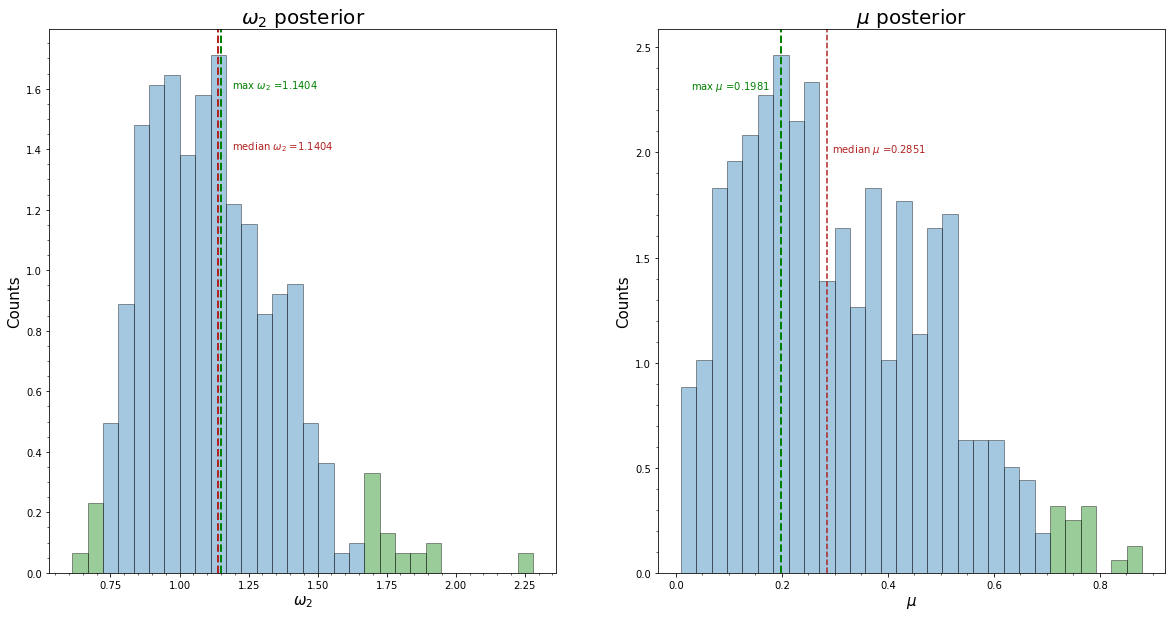

In [32]:
fig, ax = plt.subplots(1,2 , figsize=(20, 10))

# OMEGA
res_omega = ax[0].hist(sample_omega, edgecolor='black', alpha = 0.4, bins=30, density = True)
counts_omega = res_omega[0]
edges_omega = res_omega[1]
patches_omega = res_omega[2]
tmp = np.cumsum(np.diff(edges_omega)*counts_omega)

max_index = np.argmax(counts_omega)
max_omega = (edges_omega[max_index] + edges_omega[max_index + 1])/2
median_omega = (edges_omega[len(tmp[tmp<0.5])+1] + edges_omega[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_2:', round(median_omega, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega[i].set_facecolor('green')

ax[0].minorticks_on()
ax[0].set_ylabel('Counts', fontsize=15)
ax[0].set_xlabel('$\\omega_2$', fontsize=15)
ax[0].set_title('$\\omega_2$ posterior', fontsize=20)
ax[0].axvline(median_omega, color='firebrick', linestyle='dashed',  linewidth=2)
ax[0].axvline(max_omega+0.01, color='green', linestyle='dashed',  linewidth=2)
ax[0].text(median_omega+0.05, 1.4, 'median $\omega_2$ =' + str(round(median_omega, 4)), color='firebrick')
ax[0].text(max_omega+0.05, 1.6, 'max $\omega_2$ =' + str(round(max_omega, 4)), color='green')

# MU
res_mu = ax[1].hist(sample_mu, edgecolor='black', alpha = 0.4, bins=30, density = True)
counts_mu = res_mu[0]
edges_mu = res_mu[1]
patches_mu = res_mu[2]

tmp = np.cumsum(np.diff(edges_mu)*counts_mu)
max_index = np.argmax(counts_mu)
max_mu = (edges_mu[max_index] + edges_mu[max_index + 1])/2
median_mu = (edges_mu[len(tmp[tmp<0.5])+1] + edges_mu[len(tmp[tmp<0.5])+2])/2

print('Median value of mu:', round(median_mu, 4))

for i in range(len(tmp[tmp<0.025])):
    patches_mu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_mu[i].set_facecolor('green')


ax[1].minorticks_on()
ax[1].set_ylabel('Counts', fontsize=15)
ax[1].set_xlabel('$\\mu$', fontsize=15)
ax[1].set_title('$\\mu$ posterior', fontsize=20)
ax[1].axvline(median_u, color='firebrick', linestyle='dashed')
ax[1].axvline(max_u, color='green', linestyle='dashed',  linewidth=2)
ax[1].text(median_u+0.01, 2, 'median $\mu$ =' + str(round(median_u, 4)), color='firebrick')
ax[1].text(max_u-0.17, 2.3, 'max $\mu$ =' + str(round(max_u, 4)), color='green')

plt.show()

### Results
Since the values of the parameters used to generate the data are known, because they are imposed at the beginning, in this case we can compare the inferred values with the true ones.

About $\mu$, the result of the inference procedure is 
- $\text{median}(\mu)=0.2851$ 
- $\text{max}(\mu)=0.1981$

The predicted value of $\mu$ is correctly much smaller than $\nu$ and similar to the true value. 

Regarding $\omega_2$, even though the characteristic values of $\omega_2$ 
- $\text{median}(\omega_2)=1.1404$ 
- $\text{max}(\omega_2)=1.1404$

are close to the true value, the value found turns out to be greater than $\omega_1=1$, which is an important difference with respect to the imposed value, that was smaller than $\omega_1$. However, this is justified by the fact that the size of the cell in the simulated series has a strong initial drop and then remains smaller than the size at birth, suggesting that the division rate is slightly larger than the growth rate. Notice that this can happen, because the division process is stochastic and, on top of this, the generated time series is quite short (size=100).

## Metropolis–Hastings algorithm (emcee)

In [ ]:
def log_likelihood_1(y, pars=(1,0.9,0.1,1,1)):
    return np.sum(np.log(PDF(y, pars)), axis=1)


def log_likelihood_TRY(y, pars=(1,0.9,0.1,1,1)):
    try:
        log_TRY = log_likelihood_1(y, pars)
    except ValueError:
        log_TRY = -np.inf

    return (log_TRY)      #already defined

ndim, nwalkers = 1, 100
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_TRY, args=[(1,0.9,0.1,1,1)])

In [ ]:
log_likelihood_TRY(np.random.randn(100,2), (1,0.9,0.1,1,1))

<ipython-input-29-1e69c42166af>:2: RuntimeWarning:

invalid value encountered in log



array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

<ipython-input-13-1d362f4d4f7a>:16: RuntimeWarning:

divide by zero encountered in true_divide

/root/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-13-1d362f4d4f7a>:16: RuntimeWarning:

invalid value encountered in true_divide



array([[-0.04701864],
       [-0.60408132],
       [-0.89694958],
       ...,
       [-0.91652002],
       [ 0.23906116],
       [-1.75951152]])

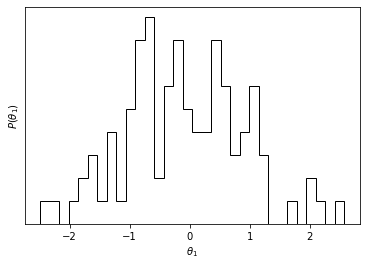

In [ ]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(state, 1000)
chain = sampler.get_chain(flat=True)

plt.hist(chain[:, 0], round(np.sqrt(1000)), color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$P(\theta_1)$")
plt.gca().set_yticks([]);

chain

In [ ]:
print(
    "Mean acceptance fraction: {0:.7f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.0000000


# References
- Held J, Lorimer T, Pomati F, Stoop R, Albert C. Second-order phase transition in phytoplankton trait dynamics. _Chaos_. 2020;30(5):053109. doi:10.1063/1.5141755 
- emcee documentation: https://emcee.readthedocs.io/en/stable/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>